In [6]:
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays
using NNlib

### True ODE Model and Synthetic Data Generation

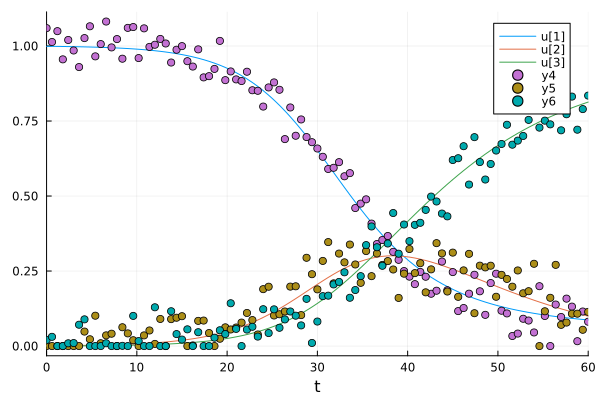

In [23]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

SIR_model(y::AbstractVector{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1] .* y[2]        
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end


# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0, 60.0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
sol_ = Array(sol)

# Add some noise
noise_sd = 0.05
noisy_data = clamp.(begin
    sol_ + noise_sd.* Random.randn(rng, size(sol_)...) 
end,0, Inf)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = Y_train[:, 1]     # IC for penalty

Plots.plot(sol)
Plots.scatter!(t_train, Y_train[1,:])
Plots.scatter!(t_train, Y_train[2,:])
Plots.scatter!(t_train, Y_train[3,:])


### Setting up the NN

In [9]:
NN_model = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3, NNlib.softplus) # forces outputs to be positive
)

ps, st = Lux.setup(rng, NN_model)
ps = ComponentArrays.ComponentArray(ps)

function predict_NN(model, ps, st, t_vec::AbstractVector{<:Real})
    t_in = reshape(Float32.(t_vec), 1, :)
    ŷ_n , _ = Lux.apply(model, t_in, ps, st)
    return ŷ_n
end


predict_NN (generic function with 1 method)

### Computing Loss

In [25]:
function MSE(ŷ, y)
    Statistics.mean(abs2, vec(ŷ .- y))
end

λ_ic = 1.0f0*100
λ_ode = 1.0f0*2

function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    model = ctx.model
    st = ctx.st
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    λ_ode = ctx.λ_ode
    SIR_par = ctx.SIR_par

    smodel = Lux.StatefulLuxLayer(model, ps, st)
    ŷ = smodel(t_train')
    data_mse = MSE(ŷ, Y_train)
    ic_mse = Statistics.mean(abs2, ŷ[:,1] .- y0_obs)
    

    f = tn -> begin
        ŷ_NN = smodel([tn])
        f_ŷ_NN = SIR_model(ŷ_NN, SIR_par)
        dNNdt_tn = Zygote.jacobian(smodel, [tn])[1]
        Statistics.mean(abs2, f_ŷ_NN .- dNNdt_tn)
        end
    ode_mse = mean(f.(ctx.t_dense))
    
    return data_mse + ic_mse *λ_ic + λ_ode*ode_mse  
end

t_dense = Float32.(range(t_train[begin], t_train[end], length=200) |> collect)
ctx = (
    model = NN_model,
    st = st,
    t_train = t_train,
    Y_train = Y_train,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    λ_ode = λ_ode,
    t_dense = t_dense,
    SIR_par = true_SIR_par

)

(model = Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(softplus), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, tanh), layer_2 = Dense(10 => 10, tanh), layer_3 = Dense(10 => 3, softplus)), nothing), st = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()), t_train = Float32[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, 5.4  …  54.6, 55.2, 55.8, 56.4, 57.0, 57.6, 58.2, 58.8, 59.4, 60.0], Y_train = Float32[1.059514 1.0133065 … 0.115106866 0.081107125; 0.0 0.0 … 0.054239936 0.11388435; 0.020175591 0.03076273 … 0.7896826 0.8346873], y0_obs = Float32[1.059514, 0.0, 0.020175591], λ_ic = 100.0f0, λ_ode = 2.0f0, t_dense = Float32[0.0, 0.30150753, 0.60301507, 0.9045226, 1.2060301, 1.5075377, 1.8090452, 2.1105528, 2.4120603, 2.7135677  …  57.28643, 57.58794, 57.889446, 58.190956, 58.492462, 58.79397

### Optimization

In [26]:

optfun = Optimization.OptimizationFunction(
    (x, p) -> loss_supervised(x,p),
    Optimization.AutoZygote()
)
prob_fit = Optimization.OptimizationProblem(optfun, ps, ctx)
res = Optimization.solve(prob_fit, OptimizationOptimisers.Adam(1e-03); maxiters=5_000)
ps_trained = res.u

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.031302627; -0.034107275; … ; -1.1292931; -0.38983703;;], bias = Float32[0.70644474, 0.83817476, 0.5682591, -0.58491534, 0.8106064, 0.79626805, -0.27133113, -0.69533616, -0.3858524, 0.20142144]), layer_2 = (weight = Float32[-0.019283911 0.41018525 … 0.27462953 0.18346612; -0.3398273 -0.3051529 … -0.91424525 -0.49278748; … ; 0.33547056 -0.050385688 … -0.08626271 -0.89276344; 0.5029178 0.5529325 … -0.6616809 -0.75293803], bias = Float32[0.3752618, 0.38651365, 0.11203872, 0.14409915, -0.26358747, -0.3287952, -0.4963515, 0.37469655, 0.28348336, 0.27239805]), layer_3 = (weight = Float32[-0.2719439 0.3405761 … -0.18353333 0.069858566; -0.557199 -0.8125627 … -0.3068047 -0.62044734; -0.58548707 -0.35759524 … -0.096766844 -0.7282579], bias = Float32[-0.2041487, -0.10568687, 0.11042221]))

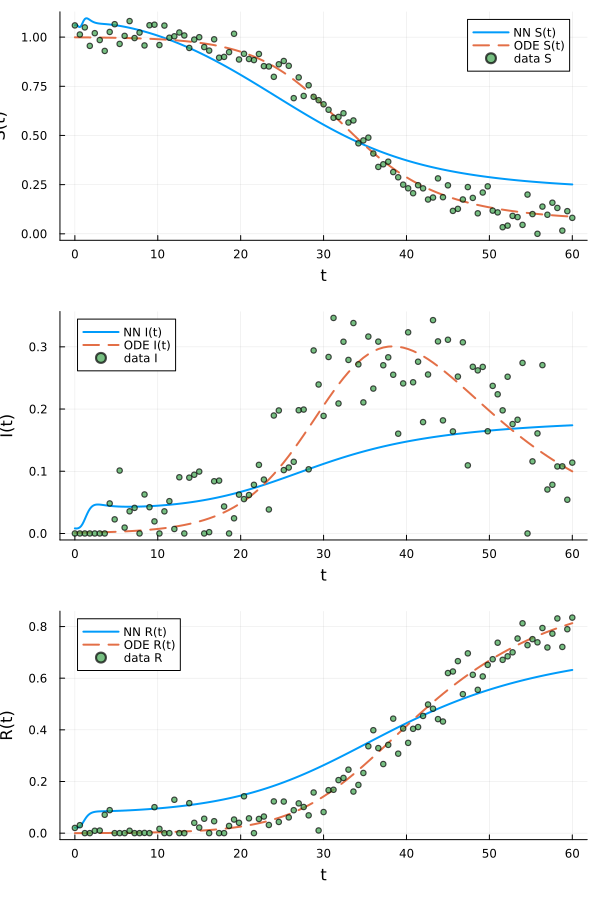

In [30]:
# Build a stateful model bound to the trained params
smodel = Lux.StatefulLuxLayer(NN_model, ps_trained, st)

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))

# NN predictions on the smooth grid (3×N)
ŷ_plot = smodel(permutedims(t_plot))  # 1×N input expected; returns 3×N

# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_nn,   I_nn,   R_nn   = vec(ŷ_plot[1, :]), vec(ŷ_plot[2, :]), vec(ŷ_plot[3, :])
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_plot, S_nn; label = "NN S(t)", linewidth = 2)
Plots.plot!(p1, t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_plot, I_nn; label = "NN I(t)", linewidth = 2)
Plots.plot!(p2, t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_plot, R_nn; label = "NN R(t)", linewidth = 2)
Plots.plot!(p3, t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)
